In [1]:
import os
import glob
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
#pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [3]:
user_name = 'CY'  # 윈도우 사용자 이름으로 변경하세요
desktop_path = f'C:\\Users\\{user_name}\\Desktop'

In [4]:
# 이미지 경로 설정
train_asym_img_path = os.path.join(desktop_path, 'eye_disease/eye_train/E1/binary/asym')
train_sym_img_path = os.path.join(desktop_path, 'eye_disease/eye_train/E1/binary/sym')
validation_asym_img_path = os.path.join(desktop_path, 'eye_disease/eye_validation/E1/binary/asym')
validation_sym_img_path = os.path.join(desktop_path, 'eye_disease/eye_validation/E1/binary/sym')

In [5]:
# 이미지 로드 및 라벨 생성 함수
def load_images_and_labels(sym_paths, asym_paths):
    images = []
    labels = []
    extensions = ['*.jpg', '*.jpeg', '*.png']  # 지원할 파일 확장자 목록

    for path in sym_paths:
        for ext in extensions:
            sym_images = glob.glob(os.path.join(path, ext))
            for image_path in sym_images:
                img = np.array(Image.open(image_path).resize((224,224)))
                images.append(img)
                labels.append(1)  # 'sym' 라벨

    for path in asym_paths:
        for ext in extensions:
            asym_images = glob.glob(os.path.join(path, ext))
            for image_path in asym_images:
                img = np.array(Image.open(image_path).resize((224,224)))
                images.append(img)
                labels.append(0)  # 'asym' 라벨

    # 로드된 이미지와 라벨 개수 출력
    print(f"Loaded {len(images)} images and {len(labels)} labels.")
    
    return np.array(images), np.array(labels)

In [6]:
# 훈련 및 검증 데이터 로드
train_images_sym, train_labels_sym = load_images_and_labels([train_sym_img_path], [])
train_images_asym, train_labels_asym = load_images_and_labels([], [train_asym_img_path])
val_images_sym, val_labels_sym = load_images_and_labels([validation_sym_img_path], [])
val_images_asym, val_labels_asym = load_images_and_labels([], [validation_asym_img_path])

Loaded 13741 images and 13741 labels.
Loaded 6880 images and 6880 labels.
Loaded 1727 images and 1727 labels.
Loaded 860 images and 860 labels.


In [7]:
# sym 파일과 asym 파일 각각 결합
sym_images = np.concatenate([train_images_sym, val_images_sym], axis=0)
sym_labels = np.concatenate([train_labels_sym, val_labels_sym], axis=0)
asym_images = np.concatenate([train_images_asym, val_images_asym], axis=0)
asym_labels = np.concatenate([train_labels_asym, val_labels_asym], axis=0)

In [8]:
# sym과 asym 개수 세기
sym_count = len(sym_labels)
asym_count = len(asym_labels)

In [9]:
# 데이터 개수 출력
print(f"Symptomatic images: {sym_count}")
print(f"Asymptomatic images: {asym_count}")

Symptomatic images: 15468
Asymptomatic images: 7740


In [10]:
# 부족한 클래스에 맞춰 데이터 증강
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

if sym_count < asym_count:
    augmentation_target = sym_images
    augmentation_target_label = 1
    target_count = asym_count
else:
    augmentation_target = asym_images
    augmentation_target_label = 0
    target_count = sym_count

augmented_images = []
augmented_labels = []

for img in augmentation_target:
    img = img.reshape((1,) + img.shape)  # (1, 224, 224, 3) 형태로 변환
    i = 0
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(augmentation_target_label)
        i += 1
        if len(augmented_labels) + len(augmentation_target) >= target_count:
            break

In [11]:
# 증강된 데이터와 원본 데이터 결합
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

if augmentation_target_label == 1:
    sym_images = np.concatenate([sym_images, augmented_images], axis=0)
    sym_labels = np.concatenate([sym_labels, augmented_labels], axis=0)
else:
    asym_images = np.concatenate([asym_images, augmented_images], axis=0)
    asym_labels = np.concatenate([asym_labels, augmented_labels], axis=0)

In [12]:
# 결합된 최종 데이터셋
images = np.concatenate([sym_images, asym_images], axis=0)
labels = np.concatenate([sym_labels, asym_labels], axis=0)

In [13]:
# 데이터를 8:2 비율로 train과 test로 나누기
X_train_val, X_test, y_train_val, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# train_val 데이터를 3:1 비율로 train과 validation으로 나누기 (전체 데이터의 6:2:2 비율)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

In [14]:
# 데이터 정규화
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [15]:
# 모델 정의
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
# 모델 훈련
history = model.fit(X_train, y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32)

# 모델 평가
score = model.evaluate(X_test, y_test)
print(f'Test accuracy: {score[1]}')

Epoch 1/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 662s 900ms/step - accuracy: 0.6294 - loss: 0.6502 - val_accuracy: 0.8012 - val_loss: 0.4583
Epoch 2/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 671s 925ms/step - accuracy: 0.8112 - loss: 0.4338 - val_accuracy: 0.6887 - val_loss: 0.5831
Epoch 3/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 675s 930ms/step - accuracy: 0.8309 - loss: 0.3877 - val_accuracy: 0.8652 - val_loss: 0.3255
Epoch 4/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 670s 923ms/step - accuracy: 0.8453 - loss: 0.3594 - val_accuracy: 0.8336 - val_loss: 0.3548
Epoch 5/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 643s 886ms/step - accuracy: 0.8500 - loss: 0.3370 - val_accuracy: 0.8389 - val_loss: 0.3392
Epoch 6/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 651s 897ms/step - accuracy: 0.8539 - loss: 0.3321 - val_accuracy: 0.8575 - val_loss: 0.3091
Epoch 7/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 654s 901ms/step - accuracy: 0.8606 - loss: 0.3213 - val_accuracy: 0.8319 - val_loss: 0.3718
Epoch 8/10
726/726 ━━━━━━━━━━━━━━━━━━━━ 650s 895ms/step - accuracy: 0.8703 -

In [17]:
# 모델 저장
model.save('E1_resnet_model.keras', include_optimizer=True)
print("Model saved as E1_resnet_model.keras")

Model saved as E1_resnet_model.keras


In [18]:
# 새로운 이미지에 대해 예측하는 함수
def predict_image(model, image_path):
    img = np.array(Image.open(image_path).resize((224, 224))) / 255.0
    img = np.expand_dims(img, axis=0)
    prediction = model.predict(img)
    return prediction

# 예측 결과 확인
prediction = predict_image(model, "C:\\Users\\CY\\Desktop\\eye_disease\\eye_validation\\E4\\asym\\crop_D0_0bec4e75-60a5-11ec-8402-0a7404972c70.png")
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: [[0.05131604]], Symptom probability: 5.13%


In [19]:
prediction = predict_image(model, "C:\\Users\\CY\\Desktop\\eye_disease\\eye_validation\\E4\\asym\\crop_D0_03b2ab5b-60a5-11ec-8402-0a7404972c70.png")
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Prediction: [[0.00332175]], Symptom probability: 0.33%


In [20]:
prediction = predict_image(model, "C:\\Users\\CY\\Desktop\\eye_disease\\eye_train\\E7\\sym\\crop_D0_1cef85e6-60a5-11ec-8402-0a7404972c70.jpg")
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Prediction: [[0.9692405]], Symptom probability: 96.92%


In [21]:
prediction = predict_image(model, "C:\\Users\\CY\\Desktop\\eye_disease\\eye_train\\E5\\asym\\crop_D0_0a00e649-60a5-11ec-8402-0a7404972c70.png")
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Prediction: [[0.38344848]], Symptom probability: 38.34%


In [22]:
prediction = predict_image(model, "C:\\Users\\CY\\Desktop\\eye_disease\\eye_train\\E1\\binary\\sym\\crop_D0_3a1ddb67-60a5-11ec-8402-0a7404972c70.jpg")
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction: [[0.9811074]], Symptom probability: 98.11%


In [23]:
prediction = predict_image(model, "C:\\Users\\CY\\Desktop\\eye_disease\\eye_train\\E1\\binary\\sym\\crop_D0_1cbc1550-60a5-11ec-8402-0a7404972c70.jpg")
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Prediction: [[0.11939143]], Symptom probability: 11.94%


In [24]:
prediction = predict_image(model, "C:\\Users\\CY\\Desktop\\eye_disease\\eye_train\\E1\\binary\\sym\\crop_D0_2fc95f5c-60a5-11ec-8402-0a7404972c70.jpg")
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Prediction: [[0.93821275]], Symptom probability: 93.82%


In [25]:
prediction = predict_image(model, "C:\\Users\\CY\\Desktop\\eye_disease\\eye_train\\E1\\binary\\sym\\crop_D0_3a1a3fca-60a5-11ec-8402-0a7404972c70.jpg")
print(f'Prediction: {prediction}, Symptom probability: {prediction[0][0]*100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Prediction: [[0.9866395]], Symptom probability: 98.66%


### confusion matrix

In [26]:
# 모델 평가를 위해 테스트 세트에서 예측 수행
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")  # 0.5를 기준으로 이진 분류

242/242 ━━━━━━━━━━━━━━━━━━━━ 169s 691ms/step


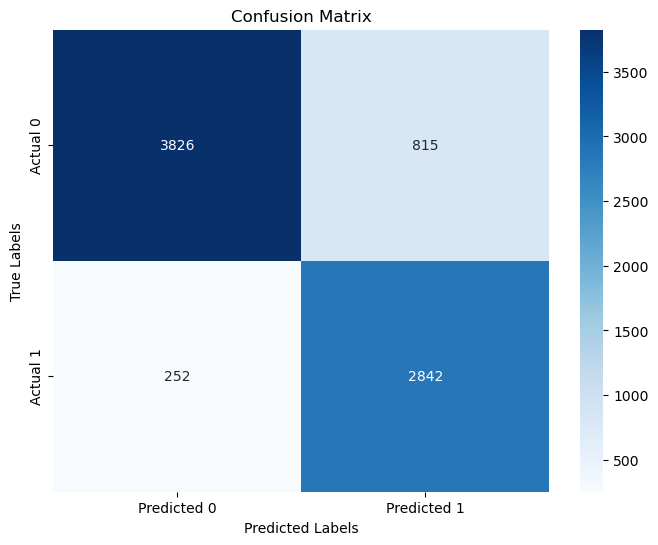

In [27]:
import seaborn as sns
# 혼동 행렬 계산
conf_matrix = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# 그래프를 파일로 저장
plt.savefig('E1_confusion_matrix.png')
plt.show()

In [28]:
# 분류 보고서 출력
class_report = classification_report(y_test, y_pred)
print('Classification Report:')
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      4641
           1       0.78      0.92      0.84      3094

    accuracy                           0.86      7735
   macro avg       0.86      0.87      0.86      7735
weighted avg       0.87      0.86      0.86      7735



In [29]:
# 개별 지표 계산
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.8620555914673562
Precision: 0.777139732020782
Recall: 0.918552036199095
F1 Score: 0.8419493408383943


AUC Score: 0.956877216601921


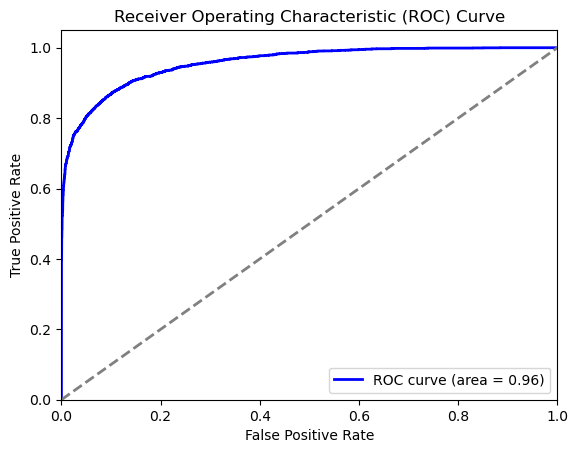

In [30]:
# ROC Curve 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)

print(f'AUC Score: {auc}')

# ROC Curve 시각화
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# 그래프를 파일로 저장
plt.savefig('E1_ROC Curve.png')
plt.show()

### 시각화

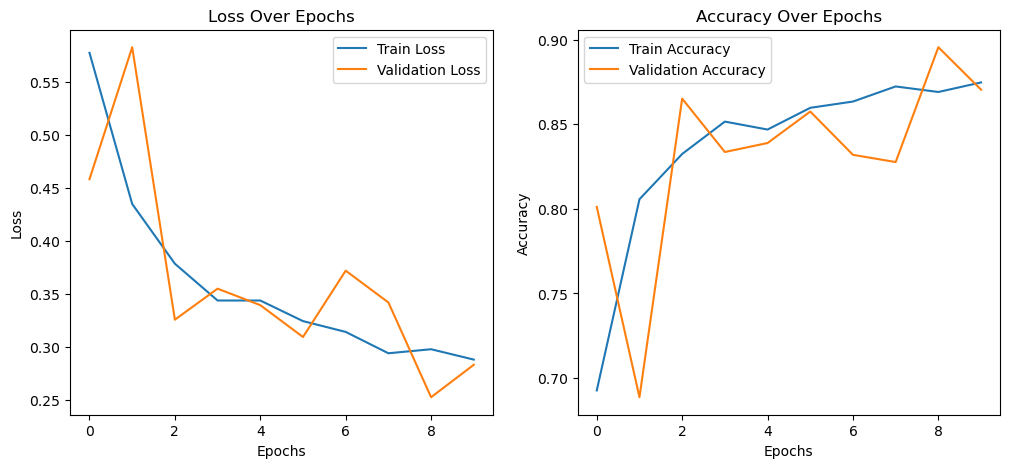

In [31]:
# 훈련 및 검증 손실 플로팅
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 훈련 및 검증 정확도 플로팅
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 그래프를 파일로 저장
plt.savefig('E1_training_validation_loss_accuracy.png')
plt.show()